# ANÁLISIS DE LA ETIQUETA NUTRISCORE

Este proyecto analiza la relación entre las características nutricionales de los alimentos y su puntuación Nutri-Score, utilizando datos de la base Open Food Facts (https://blog.openfoodfacts.org/es/). Nutri-Score es una etiqueta nutricional que clasifica los alimentos en cinco categorías (A a E) según su calidad nutricional, siendo "A" la mejor y "E" la peor. El objetivo principal es desarrollar un modelo predictivo que permita estimar tanto la puntuación numérica (nutriscore_score) como la etiqueta categórica (nutriscore_grade) a partir de variables como calorías, grasas, azúcares y proteínas. Además, se busca identificar los factores más relevantes en la determinación del Nutri-Score así como sus sesgos.


    1. Importación y limpieza de datos
    2. Distribuciones y Outliers
    3. Correlaciones y Análisis
    4. Modelización: Regresión / Clasificación
    5. Evaluación y problemas

## 1. Importación y limpieza de datos

In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [40]:
data = pd.read_csv('en.openfoodfacts.org.products.csv/en.openfoodfacts.org.products.csv', sep='\t', encoding='utf-8')

C:\Users\rdiaz\AppData\Local\Temp\ipykernel_2216\1225682318.py:1: DtypeWarning: Columns (0,8,13,22,23,27,28,29,31,52,64) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('en.openfoodfacts.org.products.csv/en.openfoodfacts.org.products.csv', sep='\t', encoding='utf-8')


Una vez cargados los datos de la base de datos Open Food Facts debemos analizar cuáles son las variables que nos ofrece, cuáles de ellas pueden ser relevantes para el análisis y cuáles no. Finalmente analizar las escalas y las medidas que se utilizan y si debemos hacer transformaciónes.

In [41]:
pd.set_option('display.max_columns', None)  # Mostrar todas las columnas
pd.set_option('display.max_rows', None)     # Mostrar todas las filas
pd.set_option('display.width', 1000) 

data.head()

,code,url,creator,created_t,created_datetime,last_modified_t,last_modified_datetime,product_name,abbreviated_product_name,generic_name,quantity,packaging,packaging_tags,packaging_text,brands,brands_tags,categories,categories_tags,categories_en,origins,origins_tags,origins_en,manufacturing_places,manufacturing_places_tags,labels,labels_tags,labels_en,emb_codes,emb_codes_tags,first_packaging_code_geo,cities,cities_tags,purchase_places,stores,countries,countries_tags,countries_en,ingredients_text,allergens,allergens_en,traces,traces_tags,traces_en,serving_size,serving_quantity,no_nutriments,additives_n,additives,additives_tags,additives_en,ingredients_from_palm_oil_n,ingredients_from_palm_oil,ingredients_from_palm_oil_tags,ingredients_that_may_be_from_palm_oil_n,ingredients_that_may_be_from_palm_oil,ingredients_that_may_be_from_palm_oil_tags,nutriscore_score,nutriscore_grade,nova_group,pnns_groups_1,pnns_groups_2,states,states_tags,states_en,brand_owner,main_category,main_category_en,image_url,image_small_url,image_ingredients_url,image_ingredients_small_url,image_nutrition_url,image_nutrition_small_url,energy-kj_100g,energy-kcal_100g,energy_100g,energy-from-fat_100g,fat_100g,saturated-fat_100g,-butyric-acid_100g,-caproic-acid_100g,-caprylic-acid_100g,-capric-acid_100g,-lauric-acid_100g,-myristic-acid_100g,-palmitic-acid_100g,-stearic-acid_100g,-arachidic-acid_100g,-behenic-acid_100g,-lignoceric-acid_100g,-cerotic-acid_100g,-montanic-acid_100g,-melissic-acid_100g,monounsaturated-fat_100g,polyunsaturated-fat_100g,omega-3-fat_100g,-alpha-linolenic-acid_100g,-eicosapentaenoic-acid_100g,-docosahexaenoic-acid_100g,omega-6-fat_100g,-linoleic-acid_100g,-arachidonic-acid_100g,-gamma-linolenic-acid_100g,-dihomo-gamma-linolenic-acid_100g,omega-9-fat_100g,-oleic-acid_100g,-elaidic-acid_100g,-gondoic-acid_100g,-mead-acid_100g,-erucic-acid_100g,-nervonic-acid_100g,trans-fat_100g,cholesterol_100g,carbohydrates_100g,sugars_100g,-sucrose_100g,-glucose_100g,-fructose_100g,-lactose_100g,-maltose_100g,-maltodextrins_100g,starch_100g,polyols_100g,fiber_100g,-soluble-fiber_100g,-insoluble-fiber_100g,proteins_100g,casein_100g,serum-proteins_100g,nucleotides_100g,salt_100g,sodium_100g,alcohol_100g,vitamin-a_100g,beta-carotene_100g,vitamin-d_100g,vitamin-e_100g,vitamin-k_100g,vitamin-c_100g,vitamin-b1_100g,vitamin-b2_100g,vitamin-pp_100g,vitamin-b6_100g,vitamin-b9_100g,folates_100g,vitamin-b12_100g,biotin_100g,pantothenic-acid_100g,silica_100g,bicarbonate_100g,potassium_100g,chloride_100g,calcium_100g,phosphorus_100g,iron_100g,magnesium_100g,zinc_100g,copper_100g,manganese_100g,fluoride_100g,selenium_100g,chromium_100g,molybdenum_100g,iodine_100g,caffeine_100g,taurine_100g,ph_100g,fruits-vegetables-nuts_100g,fruits-vegetables-nuts-dried_100g,fruits-vegetables-nuts-estimate_100g,collagen-meat-protein-ratio_100g,cocoa_100g,chlorophyl_100g,carbon-footprint_100g,carbon-footprint-from-meat-or-fish_100g,nutrition-score-fr_100g,nutrition-score-uk_100g,glycemic-index_100g,water-hardness_100g,choline_100g,phylloquinone_100g,beta-glucan_100g,inositol_100g,carnitine_100g
0,0000000000017,http://world-en.openfoodfacts.org/product/0000...,kiliweb,1529059080,2018-06-15T10:38:00Z,1561463718,2019-06-25T11:55:18Z,Vitória crackers,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,France,en:france,France,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,unknown,unknown,"en:to-be-completed, en:nutrition-facts-complet...","en:to-be-completed,en:nutrition-facts-complete...","To be completed,Nutrition facts completed,Ingr...",NaN,NaN,NaN,https://static.openfoodfacts.org/images/produc...,https://static.openfoodfacts.org/images/produc...,https://static.openfoodfacts.org/images/produc...,https://static.openfoodfacts.org/images/produc...,NaN,NaN,NaN,375.0,1569.0,NaN,7.0,3.08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N

A primera vista se observan muchas variables que no son útiles para el análisis ya que son urls y demás información adicional de la API, intentaremos hacer una selección de información relevantes centrándonos en como se construye nuestra variable dependiente: NutriScore.

En este caso tnemos 2 opciones de variable dependiente ya que la puntuación NutriScore tiene una escala numérica de -15 a 40 y una escala categórica de "E" hasta "A". A continuación se muestra la tabla de equivalencias:

![alt text](image.png)

Teniendo en cuenta que necesitamos esta variable en nuestro dataset eliminaremos todas aquellas filas con datos faltantes en la variable dependiente.

In [42]:
pd.set_option('display.max_info_rows', 100000)  # comando de pandas para que se muestren todas las filas
pd.set_option('display.max_info_columns', 100000) 

print(data.shape)

data = data.dropna(subset = ['nutriscore_score'])

data.shape

(1701965, 184)


(643898, 184)

Se ha reducido el tamaño del dataset eliminando alimentos no identificados con eqtiqueta, a continuación nos aseguramos que no haya datos faltantes en nuestras variables nutriscore_score y nutriscore_grade

In [43]:
print(data['nutriscore_score'].isnull().sum())
print(data['nutriscore_grade'].isnull().sum())

0
0


Seguidamente es preciso identificar cómo se contruye el nutriscore, así determinar qué variables podrían aportar información relvante a nuestro modelo de predicción.

Las variables dependientes:

- nutriscore_score: el valor numérico en la escala nutriscore --> numérica discreta
- nutriscore_grade: la calificación final asignada --> categórica

En primer lugar deberíamos mantener información básica de los alimentos para que sean identificables:

- product_name: nombre del producto  --> categórica
- pnns_groups_2: grupos alimenticios  --> categórica

Seguidamente debemos guardar la información nutricional más importante:

- energy-kcal_100g: calorías por 100 gramos --> numérica continua
- fat_100g: grasas por 100 gramos --> numérica continua
- saturated-fat_100g: grasas saturadas por 100 gramos --> numérica continua
- carbohydrates_100g: carbohidrtaos por 100 gramos --> numérica continua
- sugars_100g: azúcares por 100 gramos --> numérica continua
- fiber_100g: fibra por 100 gramos --> numérica continua
- protein_100g: proteinas por 100 gramos --> numérica continua
- salt_100g: sal por 100 gramos --> numérica continua
- additives_n: número de aditivos --> numérica disscreta

In [44]:
columnas_relevantes = [
    "product_name",
    "pnns_groups_2",
    "energy-kcal_100g",
    "fat_100g",
    "saturated-fat_100g",
    "carbohydrates_100g",
    "sugars_100g",
    "fiber_100g",
    "proteins_100g",
    "salt_100g",
    "additives_n",
    "nutriscore_score",
    "nutriscore_grade"
]

data_1 = data[columnas_relevantes]

data_1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 643898 entries, 3 to 1701957
Data columns (total 13 columns):
 #   Column              Dtype  
---  ------              -----  
 0   product_name        object 
 1   pnns_groups_2       object 
 2   energy-kcal_100g    float64
 3   fat_100g            float64
 4   saturated-fat_100g  float64
 5   carbohydrates_100g  float64
 6   sugars_100g         float64
 7   fiber_100g          float64
 8   proteins_100g       float64
 9   salt_100g           float64
 10  additives_n         float64
 11  nutriscore_score    float64
 12  nutriscore_grade    object 
dtypes: float64(10), object(3)
memory usage: 68.8+ MB


¿Tenemos datos faltantes en nuestro nuevo dataFrame?

In [45]:
data_1.isnull().sum()

product_name            2177
pnns_groups_2              0
energy-kcal_100g       42211
fat_100g                1677
saturated-fat_100g      1697
carbohydrates_100g      1946
sugars_100g             1688
fiber_100g            268905
proteins_100g           1677
salt_100g               1264
additives_n           173127
nutriscore_score           0
nutriscore_grade           0
dtype: int64

Para resolver el problema de los datos faltantes hay diferentes opciones:

- Imputar valores: opción que descartamos debido a la dificultad para imputar valores como fibra o additivos en base otros criterios
- Eliminar variables: si tuviéramos variables que pensáramos que podían ser irrelevantes o poco importantes las podríamos eliminar
- Eliminar las observaciones faltantes: debido a la gran muestra que tenemos de mas de 600.000 alimentos optaré por eliminar aquellos sin datos para todas las variables, si la muestra final sigue siendo suficiente habrá sido la mejor opción

In [46]:
# Tenemos en cuenta que la categoria de grupos aliemntiicos "unknown" debe ser NaN

data_1['pnns_groups_2'] = data_1['pnns_groups_2'].replace('unknown', np.nan)

C:\Users\rdiaz\AppData\Local\Temp\ipykernel_2216\1557557105.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_1['pnns_groups_2'] = data_1['pnns_groups_2'].replace('unknown', np.nan)


In [47]:
data_1 = data_1.dropna(subset = (columnas_relevantes))
data_1.info()
data_1.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
Index: 253596 entries, 68 to 1701765
Data columns (total 13 columns):
 #   Column              Dtype  
---  ------              -----  
 0   product_name        object 
 1   pnns_groups_2       object 
 2   energy-kcal_100g    float64
 3   fat_100g            float64
 4   saturated-fat_100g  float64
 5   carbohydrates_100g  float64
 6   sugars_100g         float64
 7   fiber_100g          float64
 8   proteins_100g       float64
 9   salt_100g           float64
 10  additives_n         float64
 11  nutriscore_score    float64
 12  nutriscore_grade    object 
dtypes: float64(10), object(3)
memory usage: 27.1+ MB


product_name          0
pnns_groups_2         0
energy-kcal_100g      0
fat_100g              0
saturated-fat_100g    0
carbohydrates_100g    0
sugars_100g           0
fiber_100g            0
proteins_100g         0
salt_100g             0
additives_n           0
nutriscore_score      0
nutriscore_grade      0
dtype: int64

Finalmente conseguimos un dataset con nuestras variables importantes muy completo y con buena cantidad observaciones ✅

## 2. Distribuciones y Outliers

Una vez contruido el data set y tratados los datos faltantes cabe estudiar las variables que vamos a emplear, veamos sus distribuciones en histogramas

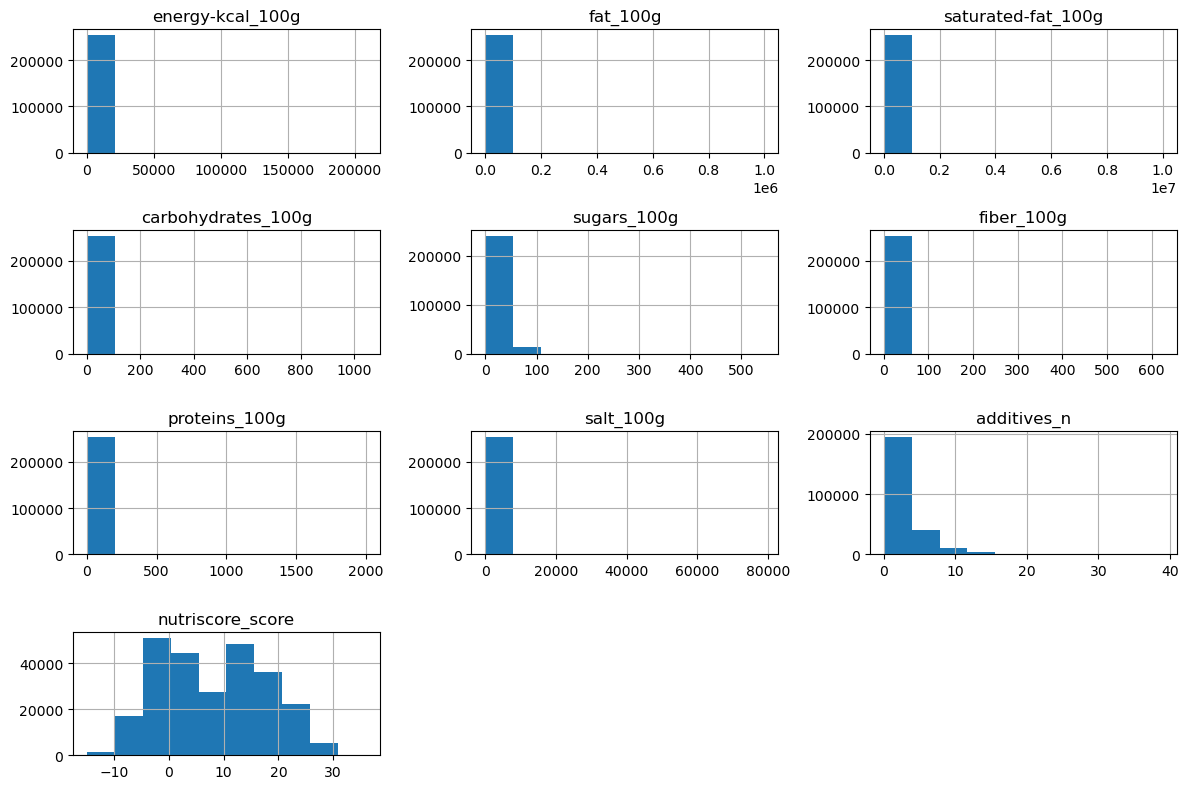

In [48]:
data_1.hist(figsize=(12, 8), bins=10)
plt.tight_layout()
plt.show()

¿Puede ser que tengamos un problema de outliers que nos estiran el eje x?

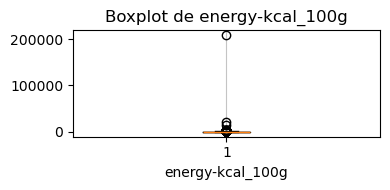

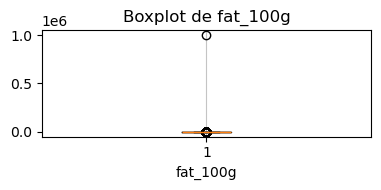

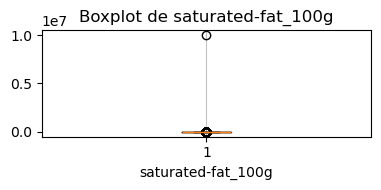

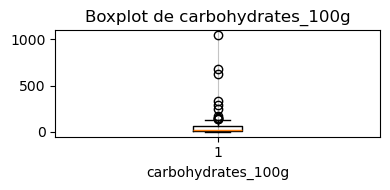

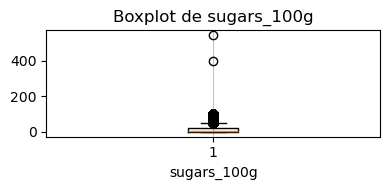

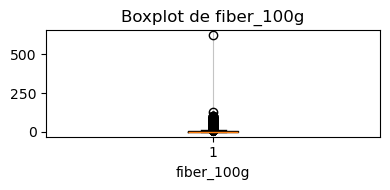

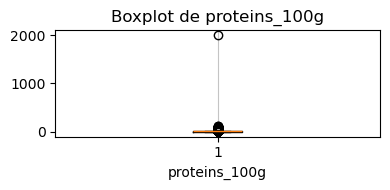

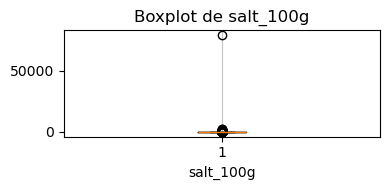

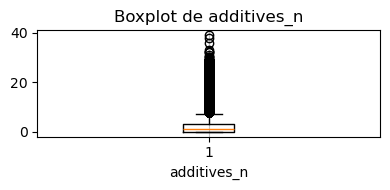

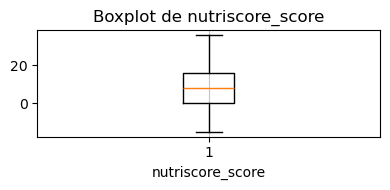

In [49]:
import matplotlib.pyplot as plt

for column in data_1.select_dtypes(include='number'):
    plt.figure(figsize=(4, 2))
    plt.boxplot(data_1[column].dropna(), vert=True)
    plt.title(f'Boxplot de {column}')
    plt.xlabel(column)
    plt.grid(axis='x', alpha=0.75)
    plt.tight_layout()
    plt.show()

Debemos aplicar el IQR para eliminar los outliers de nuestras variables nutricionales, definiremos una función

In [50]:
def filtro_outliers_relajado(df, columnas):

    Q1 = df[columnas].quantile(0.25)
    Q3 = df[columnas].quantile(0.75)
    IQR = Q3 - Q1

    limite_inf = Q1 - 1.5 * IQR
    limite_sup = Q3 + 1.5 * IQR

    condicion = (df[columnas] >= limite_inf) & (df[columnas] <= limite_sup)
    df_filtrado = df[condicion.all(axis=1)]

    return df_filtrado

In [51]:
columnas_filtro = ["energy-kcal_100g",
    "fat_100g",
    "saturated-fat_100g",
    "carbohydrates_100g",
    "sugars_100g",
    "fiber_100g",
    "proteins_100g",
    "salt_100g",
    "additives_n"]



data_2 = filtro_outliers_relajado(data_1, columnas_filtro)

Una vez aplicada la función veamos como quedan las distribuciones de nuestras variables

In [52]:
data_2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 173677 entries, 68 to 1701760
Data columns (total 13 columns):
 #   Column              Dtype  
---  ------              -----  
 0   product_name        object 
 1   pnns_groups_2       object 
 2   energy-kcal_100g    float64
 3   fat_100g            float64
 4   saturated-fat_100g  float64
 5   carbohydrates_100g  float64
 6   sugars_100g         float64
 7   fiber_100g          float64
 8   proteins_100g       float64
 9   salt_100g           float64
 10  additives_n         float64
 11  nutriscore_score    float64
 12  nutriscore_grade    object 
dtypes: float64(10), object(3)
memory usage: 18.6+ MB


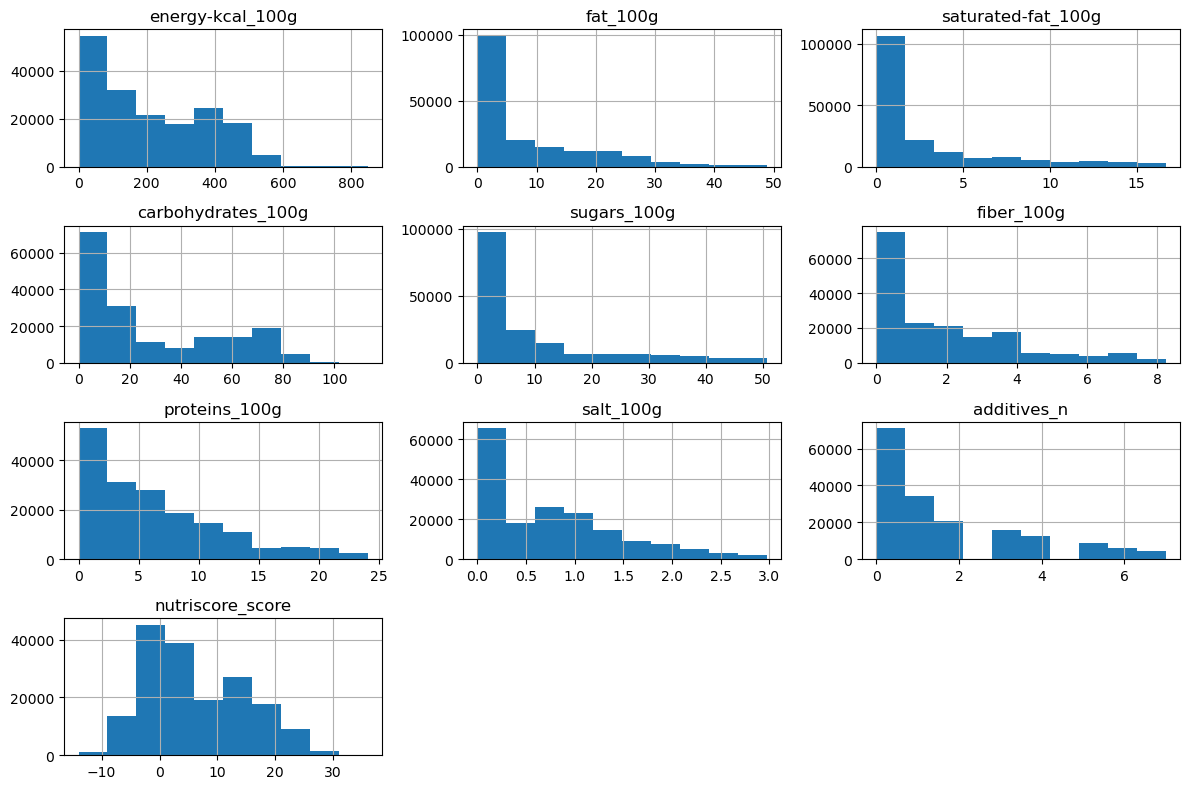

In [53]:
data_2.hist(figsize=(12, 8), bins=10)  
plt.tight_layout()
plt.show()

Ahora se visualizan claramente las distribuciones de nuestras variables que son en su mayoría asimétricas a la izquierda porque la mayoria de los alimentos tienen valores bajos de estos componentes. A excepción de nuestra variable dependiente cuyos valores se concentran alrededor del 0.

En consecuencia debemos tener en cuenta que las medidas de tendencia central como la media serán malos indicadores de centralidad de nuestras variables, la moda y la mediana serán más acertadas. Como observamos en la tabla inferior, la media a veces está más cercana al percentil 75 que a la mediana (percentil 50).

In [54]:
data_2.describe()

,energy-kcal_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,additives_n,nutriscore_score
count,173677.000000,173677.000000,173677.000000,173677.000000,173677.000000,173677.000000,173677.000000,173677.00000,173677.000000,173677.000000
mean,210.715074,7.950009,2.620390,28.123528,9.642918,1.844428,6.344949,0.73848,1.648877,5.673492
std,159.310075,9.898449,3.943810,26.754720,12.291682,2.003120,5.686830,0.70006,1.941342,8.647407
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,-14.000000
25%,66.000000,0.490000,0.000000,6.250000,1.300000,0.000000,1.600000,0.10000,0.000000,-1.000000
50%,171.000000,3.300000,0.620000,15.000000,4.000000,1.300000,5.100000,0.62000,1.000000,3.000000
75%,356.000000,13.000000,3.570000,52.000000,12.500000,3.000000,9.500000,1.15000,3.000000,13.000000
max,848.000000,48.800000,16.670001,113.000000,50.700000,8.240000,24.070000,2.97250,7.000000,36.000000


Ya hemos analizado las variables numéricas pero aún no hemos tratado con nuestra variable de grupos alimenticios observémosla para ver sus características y determinar su relevancia para el modelo.

In [55]:
data_2['pnns_groups_2'].value_counts() ### Tiene un exceso de categorías deberíamos intentar reducirlas para facilitar la futura interpretación del modelo

pnns_groups_2
Biscuits and cakes                  19604
One-dish meals                      16423
Cereals                             16295
Dressings and sauces                15473
Milk and yogurt                     11199
Bread                                9344
Vegetables                           8743
Processed meat                       6259
Sweets                               6095
Fish and seafood                     6047
Fruits                               6025
Sweetened beverages                  5221
Meat                                 4733
Unsweetened beverages                4580
vegetables                           4405
Cheese                               4332
Appetizers                           3545
Legumes                              3018
Pizza pies and quiche                2973
Plant-based milk substitutes         2547
Breakfast cereals                    2465
Fruit juices                         1814
Ice cream                            1574
Artificially sweeten

In [56]:
agrupaciones = {
    # Grupo: Panadería y Repostería
    'Biscuits and cakes': 'Pan y Dulces',
    'pastries': 'Pan y Dulces',
    'Bread': 'Pan y Dulces',
    'Breakfast cereals': 'Pan y Dulces',
    
    # Grupo: Lácteos
    'Milk and yogurt': 'Lácteos',
    'Cheese': 'Lácteos',
    'Dairy desserts': 'Lácteos',
    'Plant-based milk substitutes': 'Lácteos',
    
    # Grupo: Bebidas
    'Sweetened Bebidas y Refrescos': 'Bebidas y Refrescos',
    'Unsweetened Bebidas y Refrescos': 'Bebidas y Refrescos',
    'Teas and herbal teas and coffees': 'Bebidas y Refrescos',
    'Artificially sweetened Bebidas y Refrescos': 'Bebidas y Refrescos',
    'Waters and flavored waters': 'Bebidas y Refrescos',
    'Fruit juices': 'Bebidas y Refrescos',
    'Fruit nectars': 'Bebidas y Refrescos',
    'Alcoholic Bebidas y Refrescos': 'Bebidas y Refrescos',
    
    # Grupo: Carnes y Pescados
    'Processed meat': 'Carnes y Pescados',
    'Meat': 'Carnes y Pescados',
    'Fish and seafood': 'Carnes y Pescados',
    'Offals': 'Carnes y Pescados',
    
    # Grupo: Vegetales y Frutas
    'Vegetables': 'Frutas y Verduras',
    'Fruits': 'Frutas y Verduras',
    'legumes': 'Frutas y Verduras',
    'vegetables': 'Frutas y Verduras',
    'fruits': 'Frutas y Verduras',
    'Legumes': 'Frutas y Verduras',
    'Dried fruits': 'Frutas y Verduras',
    'Nuts': 'Frutas y Verduras',
    'nuts': 'Frutas y Verduras',
    
    # Grupo: Productos Grasos
    'Dressings and sauces': 'Fats & Oils',
    'Fats': 'Fats & Oils',
    
    # Grupo: Platos preparados
    'One-dish meals': 'Comidas Preparadas',
    'Pizza pies and quiche': 'Comidas Preparadas',
    'Pizza pies and quiches': 'Comidas Preparadas',
    'Sandwiches': 'Comidas Preparadas',
    'Appetizers': 'Comidas Preparadas',
    'Soups': 'Comidas Preparadas',
    
    # Grupo: Snacks y Dulces
    'Sweets': 'Snacks',
    'Chocolate products': 'Snacks',
    'Ice cream': 'Snacks',
    'Salty and fatty products': 'Snacks',
    
    # Grupo: Otros
    'Eggs': 'Others',
    'Potatoes': 'Others',
    'cereals': 'Others',
}

data_2['pnns_groups_2_agrupado'] = data_2['pnns_groups_2'].replace(agrupaciones)

data_2['pnns_groups_2_agrupado'].value_counts()

C:\Users\rdiaz\AppData\Local\Temp\ipykernel_2216\3720642312.py:65: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_2['pnns_groups_2_agrupado'] = data_2['pnns_groups_2'].replace(agrupaciones)


pnns_groups_2_agrupado
Pan y Dulces                        32194
Comidas Preparadas                  24966
Frutas y Verduras                   23124
Lácteos                             19194
Carnes y Pescados                   17162
Fats & Oils                         16322
Cereals                             16295
Snacks                               9162
Sweetened beverages                  5221
Unsweetened beverages                4580
Bebidas y Refrescos                  2513
Artificially sweetened beverages     1532
Others                               1406
Alcoholic beverages                     6
Name: count, dtype: int64

Una vez resumia la variable cabe determinar si es o no relevante para el modelo. Cómo tenemos 2 variables dependientes contemplamos realizar 2 tests estadísticos de significancia, uno respecto a nutriscore_score y otro respecto a nutriscore_grade.

- Para determinar la relevancia de nuestra variable categórica respecto a la dependiente categórica necesitamos un test de Chi_cuadrado para evaluar esta relación y determinar su significancia estadística.

- Para determinar la relevancia respecto a nutriscore_score en cambio, necesitaremos hacer un test ANOVA.

In [57]:
# Test Chi2

from scipy.stats import chi2_contingency

# Creo una tabla de contingencia
tabla_contingencia = pd.crosstab(data_2['pnns_groups_2_agrupado'], data_2['nutriscore_grade'])

# Test de Chi-cuadrado
chi2, p, dof, expected = chi2_contingency(tabla_contingencia)

print(f"Estadístico Chi-cuadrado: {chi2}")
print(f"Valor p: {p}") 

Estadístico Chi-cuadrado: 111969.36956110365
Valor p: 0.0


In [58]:
# Test ANOVA

from scipy.stats import f_oneway

# Separar las observaciones por categoría
grupos = [group['nutriscore_score'].values for name, group in data_2.groupby('pnns_groups_2_agrupado')]

# Test ANOVA
f_stat, p_value = f_oneway(*grupos)

print(f"Estadístico F: {f_stat}")
print(f"Valor p: {p_value}")

Estadístico F: 7672.529957194326
Valor p: 0.0


En ambos casos tenemos p-values inferiores a 0,05, por lo tanto, debemos incluir nuestra variable a ambos modelos.

## 3. Correlaciones y Análisis

Analizaremos la potencial relación entre la variable dependiente y las diferentes variables predictoras.

Antes de analizar nuestras variables cabe puntualizar como estan especificadas nuestras variables dependientes:

- nutrscore_score: puntuación numérica del nutriscore donde los valores más bajos equivalen a una mejor puntuación y los más altos a una peor
- nutriscore_grade: equivalencia en etiquetas en función de la variable numérica de la A a la E.

Seguidamente elaboramos gráficos de dispersión para identificar patrones y etndencias entre nuestra variable dependiente y los predictores

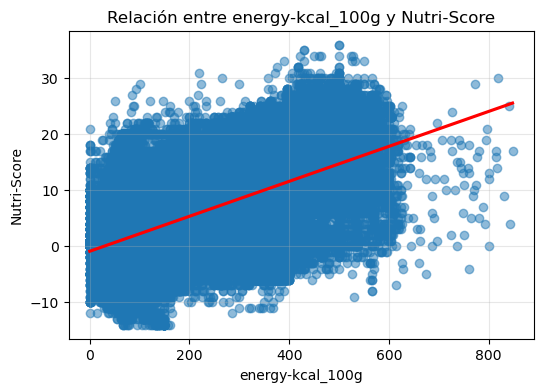

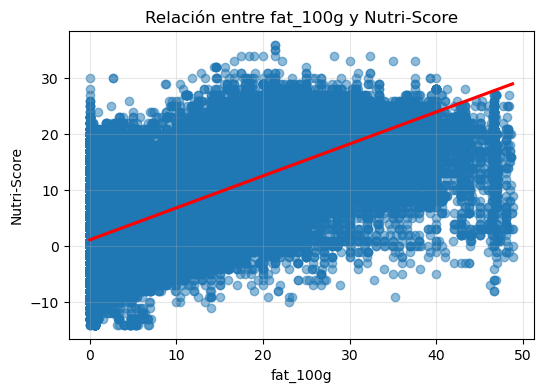

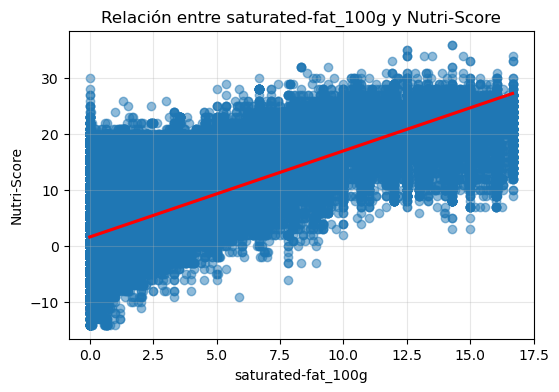

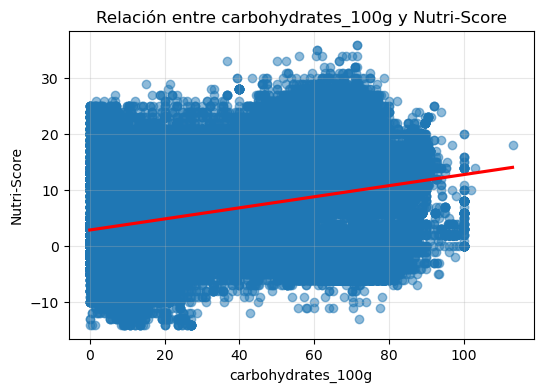

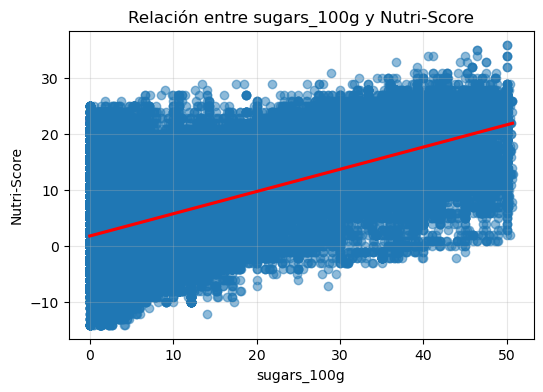

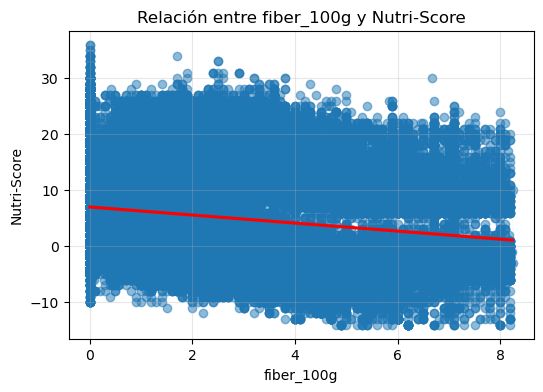

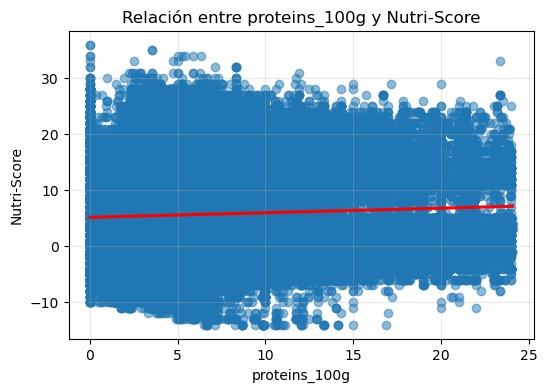

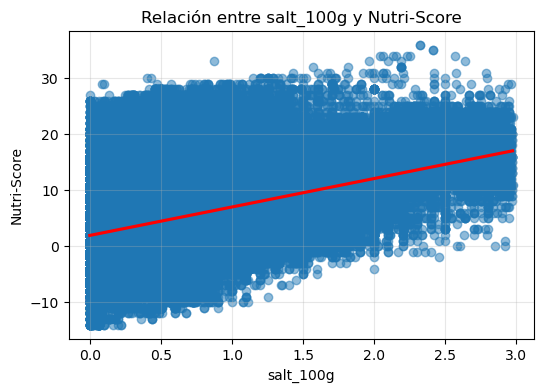

In [59]:
predictoras = ['energy-kcal_100g', 'fat_100g', 'saturated-fat_100g', 'carbohydrates_100g',
               'sugars_100g', 'fiber_100g', 'proteins_100g', 'salt_100g']

for columna in predictoras:
    plt.figure(figsize=(6, 4))
    sns.regplot(x=columna, y='nutriscore_score', data=data_2, scatter_kws={'alpha':0.5}, line_kws={'color':'red'})
    plt.title(f'Relación entre {columna} y Nutri-Score')
    plt.xlabel(columna)
    plt.ylabel('Nutri-Score')
    plt.grid(alpha=0.3)
    plt.show()

Claramente hay variables que parecen tener una relación positiva con el nutriscore, es decir, a mayores valores de grasas, calorías, azúcares y sal; peores valores del nutriscore (más altos). En cambio, la fibra tiene una relación negativa y por tanto propiciaría una mejor etiqueta en nuestra escalara valorativa. Otros como las proteínas parecen no tener una relación clara.

Veamos a continuación la relación entre las variables azúcares y calorías para identificar patrones entre variables predictoras.

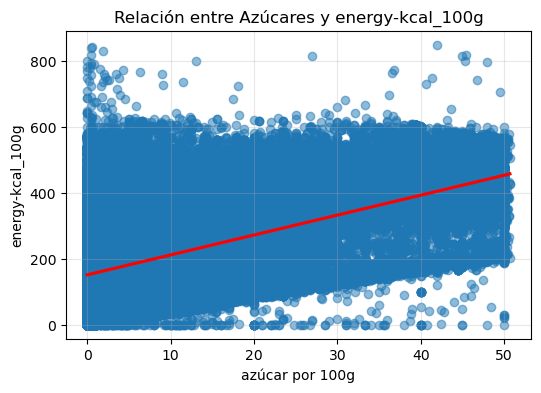

In [60]:
plt.figure(figsize=(6, 4))
sns.regplot(x='sugars_100g', y='energy-kcal_100g', data=data_2, scatter_kws={'alpha':0.5}, line_kws={'color':'red'})
plt.title(f'Relación entre Azúcares y energy-kcal_100g')
plt.xlabel('azúcar por 100g')
plt.ylabel('energy-kcal_100g')
plt.grid(alpha=0.3)
plt.show()

Vemos una relación positiva, a continuación añadire los colores de las etiquetas de nutriscore para identificar como se ubican en este grafico las etiquetas

In [61]:
data_2['nutriscore_grade'] = data_2['nutriscore_grade'].str.upper()

data_2['nutriscore_grade'] = pd.Categorical(data_2['nutriscore_grade'], categories=['A', 'B', 'C', 'D', 'E'], ordered=True)

data_2['nutriscore_grade'].value_counts()

C:\Users\rdiaz\AppData\Local\Temp\ipykernel_2216\3734785150.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_2['nutriscore_grade'] = data_2['nutriscore_grade'].str.upper()
C:\Users\rdiaz\AppData\Local\Temp\ipykernel_2216\3734785150.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_2['nutriscore_grade'] = pd.Categorical(data_2['nutriscore_grade'], categories=['A', 'B', 'C', 'D', 'E'], ordered=True)


nutriscore_grade
A    48804
C    36265
D    36067
B    29955
E    22586
Name: count, dtype: int64

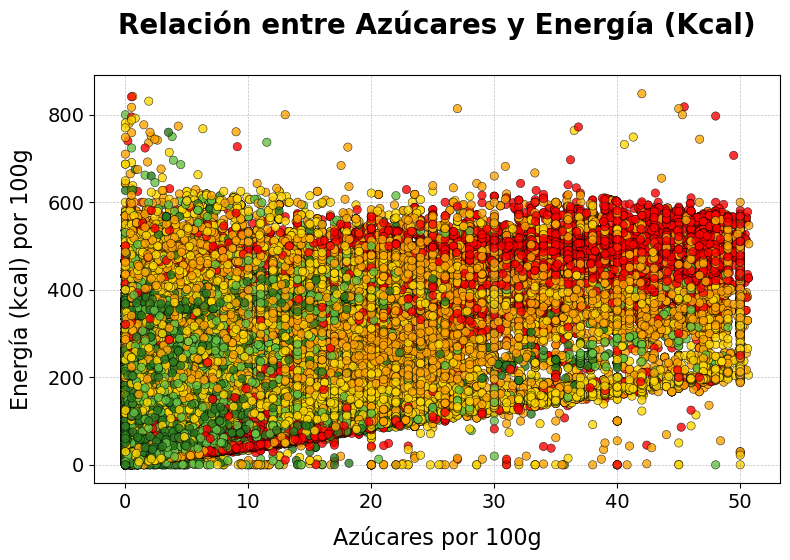

In [62]:
import matplotlib.pyplot as plt
import seaborn as sns

# Definir los colores reales del Nutri-Score
nutriscore_palette = {
    'A': '#2d7a1f',  # Verde oscuro
    'B': '#65c242',  # Verde claro
    'C': '#ffd700',  # Amarillo
    'D': '#ffa500',  # Naranja
    'E': '#ff0000'   # Rojo
}

# Crear el scatter plot
plt.figure(figsize=(8, 6))
sns.scatterplot(
    x='sugars_100g',
    y='energy-kcal_100g',
    data=data_2,
    hue='nutriscore_grade',    # Colorear según el Nutri-Score grade
    palette=nutriscore_palette,  # Usar la paleta personalizada
    alpha=0.8,                 # Mayor transparencia para más claridad
    edgecolor='black',         # Borde en los puntos para mayor definición
    linewidth=0.4,
    legend=False              # Grosor del borde
)

# Personalización del gráfico
plt.title(
    'Relación entre Azúcares y Energía (Kcal)', 
    fontsize=20, weight='bold', pad=30  # Aumentar separación con el subtítulo
)

plt.xlabel('Azúcares por 100g', fontsize=16, labelpad=10)
plt.ylabel('Energía (kcal) por 100g', fontsize=16, labelpad=10)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# Ajustar la cuadrícula
plt.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.5)



# Ajustar márgenes globales
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Reducir el margen superior
plt.show()


Observamos como abundan los alimentos con puntuaciones E (rojas) en el cuadrante superior derecho donde se concentran los productos con mayores valores de calorías y azúcares. En cambio, la etiqueta A (verde oscuro) se concentra en el cuadrante inferior izquierdo en productos con bajos valores de ambas variables.

Grafiquemos también algunos grupos de alimentos más relevantes para determinar su distribución respecto a las etiquetas de nutriscore.

C:\Users\rdiaz\AppData\Local\Temp\ipykernel_2216\2955657712.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['pnns_groups_2_agrupado'] = pd.Categorical(


<Figure size 800x600 with 0 Axes>

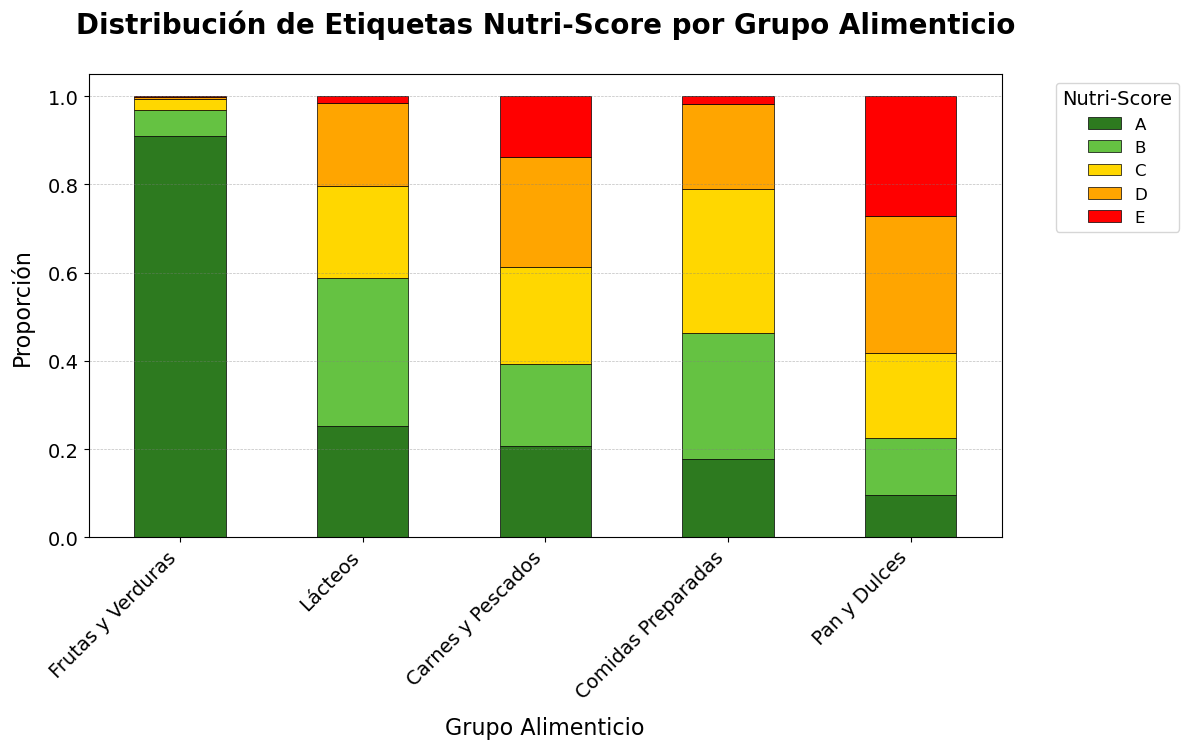

In [63]:
import matplotlib.pyplot as plt
import seaborn as sns

# Orden deseado para los grupos alimenticios
desired_groups = ['Frutas y Verduras', 'Lácteos', 'Carnes y Pescados', 'Comidas Preparadas', 'Pan y Dulces']

# Filtrar datos según los grupos deseados
filtered_data = data_2[data_2['pnns_groups_2_agrupado'].isin(desired_groups)]

# Asegurar que los grupos estén en el orden correcto
filtered_data['pnns_groups_2_agrupado'] = pd.Categorical(
    filtered_data['pnns_groups_2_agrupado'], categories=desired_groups, ordered=True
)

# Crear tabla de contingencia (proporciones de Nutri-Score por grupo alimenticio)
contingencia = pd.crosstab(
    filtered_data['pnns_groups_2_agrupado'],
    filtered_data['nutriscore_grade'],
    normalize='index'
)

# Crear el gráfico de barras apiladas
plt.figure(figsize=(8, 6))
ax = contingencia.plot(
    kind='bar',
    stacked=True,
    figsize=(12, 8),
    color=[nutriscore_palette[grade] for grade in contingencia.columns],
    edgecolor='black',  # Borde en las barras para mayor definición
    linewidth=0.5
)

# Título principal
plt.title(
    'Distribución de Etiquetas Nutri-Score por Grupo Alimenticio', 
    fontsize=20, weight='bold', pad=30
)

plt.xlabel('Grupo Alimenticio', fontsize=16, labelpad=10)
plt.ylabel('Proporción', fontsize=16, labelpad=10)
plt.xticks(fontsize=14, rotation=45, ha='right')
plt.yticks(fontsize=14)
plt.legend(
    title='Nutri-Score', 
    title_fontsize=14, 
    fontsize=12, 
    bbox_to_anchor=(1.05, 1), 
    loc='upper left'
)

plt.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.5, axis='y')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


Para poder confirmar estas relaciones observadas en los gráficos anteriores debemos calcular la correlación entre las distintas variables.

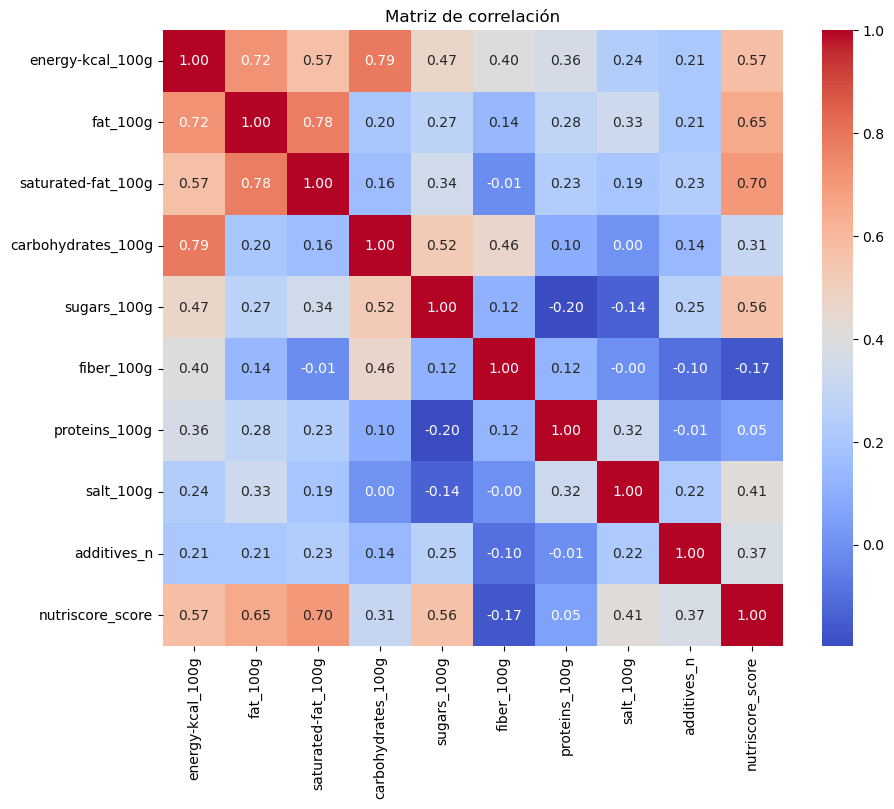

In [64]:
numerical_columns = data_2.select_dtypes(include='number').columns

correlaciones = data_2[numerical_columns].corr()

plt.figure(figsize=(10, 8))  # Ajustar el tamaño de la figura
sns.heatmap(correlaciones, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Matriz de correlación")
plt.show()


Confirmamos las relaciones observadas gráficamente:

- energía (kcal), grasas, grasas saturadas y azúcares: tienen fuerte correlación positiva (0,5 - 1) --> aumentos de estas variables correlacionan con valores más altos y negativos de nutriscore
- sal, número de aditivos y proteínas: tienen ligera correlación positiva (0 - 0,5) --> aumentos de estas variables correlacionan con valores ligeramente más altos y ligeramente más negativos de nutriscore
- fibra : correlación ligeramente negativa (0 - -0,5) --> aumentos de estas variables correlacionan con valores ligeramente más bajos y más positivos de nutriscore 

## 4. Modelo de regresión / clasificación

A continuación elaboraremos un modelo de regresión para nuestra variable nutriscore_score y un modelo de clasificación para nutriscore_grade, con las diferentes variables que hemos trabajado anteriormente



Primeramente debemos transformar nuestra variable categórica, utilizaremos el One-Hot_Emcoding para que no exista un orden entre las variables

In [65]:
# One-Hot Encoding
data_encoded = pd.get_dummies(data_2, columns=['pnns_groups_2_agrupado'], drop_first=True)

El siguiente paso para elaborar un modelo es la división de nuestro dataset en conjunto de entrenamiento y prueba

In [66]:
from sklearn.model_selection import train_test_split

dummy_columns = [col for col in data_encoded.columns if col.startswith('pnns_groups_2_agrupado')]

X = data_encoded[dummy_columns + ['energy-kcal_100g', 'fat_100g', 'sugars_100g', 'fiber_100g', 'proteins_100g', 'salt_100g', 'additives_n']]

y_score = data_encoded['nutriscore_score']
y_grade = data_encoded['nutriscore_grade']

X_train, X_test, y_train_score, y_test_score = train_test_split(X, y_score, test_size=0.3, random_state=42)
_, _, y_train_grade, y_test_grade = train_test_split(X, y_grade, test_size=0.3, random_state=42)


Debemos estandarizar nuestra escala, ya que sobre todo la regresión logística es sensible a la diferencia de escalas, aunque debemos excluir la variable categórica de esta transformación.

In [67]:
# Seleccionar columnas numéricas
num_columns = X_train.select_dtypes(include=['float64', 'int64']).columns

# Filtrar solo las columnas numéricas
X_train_num = X_train[num_columns]
X_test_num = X_test[num_columns]


from sklearn.preprocessing import StandardScaler

# Crear el escalador
scaler = StandardScaler()

# Estandarizar los datos numéricos
X_train_scaled_num = scaler.fit_transform(X_train_num)
X_test_scaled_num = scaler.transform(X_test_num)

# Combinar columnas numéricas escaladas y categóricas originales
X_train_scaled = pd.concat(
    [pd.DataFrame(X_train_scaled_num, columns=num_columns, index=X_train.index),
     X_train.drop(columns=num_columns)],
    axis=1
)

X_test_scaled = pd.concat(
    [pd.DataFrame(X_test_scaled_num, columns=num_columns, index=X_test.index),
     X_test.drop(columns=num_columns)],
    axis=1
)



Aplicamos el modelo de regresión lineal

In [68]:
from sklearn.linear_model import LinearRegression

model_reg = LinearRegression()
model_reg.fit(X_train, y_train_score)


LinearRegression()

A continuación evaluamos el funcionamiento del mismo

In [69]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

y_pred_score = model_reg.predict(X_test)
print(f"MAE: {mean_absolute_error(y_test_score, y_pred_score)}")
print(f"MSE: {mean_squared_error(y_test_score, y_pred_score)}")
print(f"RMSE: {mean_squared_error(y_test_score, y_pred_score, squared=False)}")
print(f"R²: {r2_score(y_test_score, y_pred_score)}")


MAE: 2.164391356810657
MSE: 8.151071284453787
RMSE: 2.8550081058473
R²: 0.8912345082858971


c:\Users\rdiaz\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Parece que el modelo tiene un buen desempeño, los errores tiene valores relativamente bajos y el R cuadrado es 0.88 muy cercano a 1, es decir explicamos bastante parte de la varianza del modelo. Veamos a continuación el gráfico de relación entre las variables predichas y reales.

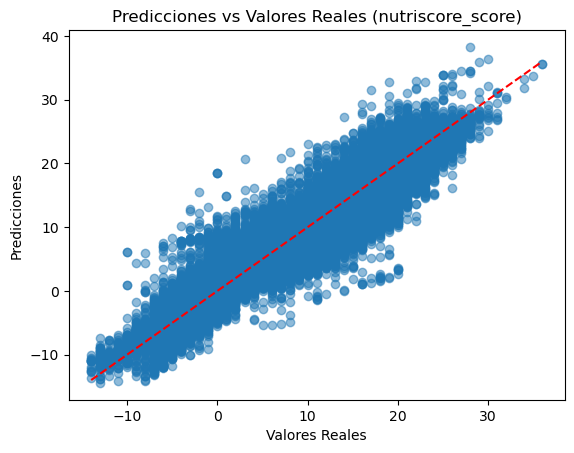

In [70]:
import matplotlib.pyplot as plt

plt.scatter(y_test_score, y_pred_score, alpha=0.5)
plt.plot([y_test_score.min(), y_test_score.max()], [y_test_score.min(), y_test_score.max()], '--', color='red')
plt.title('Predicciones vs Valores Reales (nutriscore_score)')
plt.xlabel('Valores Reales')
plt.ylabel('Predicciones')
plt.show()

Una relación muy buena entre predicciones y valores reales, el modelo parece funcionar bastante bien.

A continuación llevaremos a cabo el mismo método para el modelo de clasificación y observaremos si podemos predecir con mayor exactitud la variable nutriscore_grade o nutriscore_score

In [71]:
from sklearn.ensemble import RandomForestClassifier

model_clf = RandomForestClassifier(random_state=42)
model_clf.fit(X_train, y_train_grade)

RandomForestClassifier(random_state=42)

Exactitud: 0.8939620758483033
Reporte de clasificación:
              precision    recall  f1-score   support

           A       0.96      0.95      0.96     14617
           B       0.86      0.86      0.86      8945
           C       0.85      0.85      0.85     10852
           D       0.86      0.89      0.87     10885
           E       0.92      0.89      0.90      6805

    accuracy                           0.89     52104
   macro avg       0.89      0.89      0.89     52104
weighted avg       0.89      0.89      0.89     52104



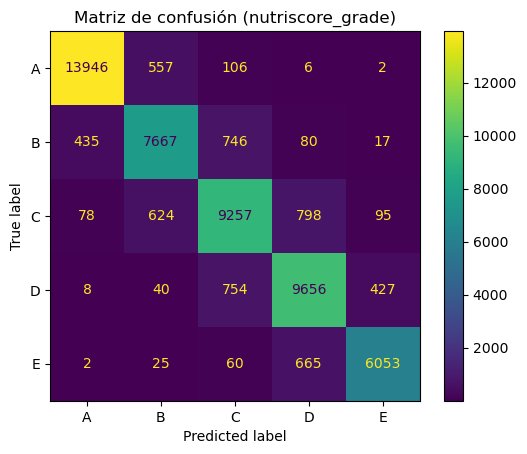

In [72]:
from sklearn.metrics import classification_report, accuracy_score, ConfusionMatrixDisplay

y_pred_grade = model_clf.predict(X_test)

print(f"Exactitud: {accuracy_score(y_test_grade, y_pred_grade)}")
print("Reporte de clasificación:")
print(classification_report(y_test_grade, y_pred_grade))

ConfusionMatrixDisplay.from_estimator(model_clf, X_test, y_test_grade)
plt.title('Matriz de confusión (nutriscore_grade)')
plt.show()

El modelo de clasificación random forest parece tener un buen desempeño también, su nivel de exactitud llega al 89%, todas las categorías de nutriscore_grade se han predicho con una exactitud y fiabilidad bastante alta.

Para hacer una interpretación y análisis de los modelos es necesario evaluar los coeficientes de los modelos


In [73]:
import statsmodels.api as sm

X_train = X_train.astype(float)
X_test = X_test.astype(float)

# Paso 2: Agregar la constante
X_train_sm = sm.add_constant(X_train)

# Paso 3: Ajustar el modelo
model_sm = sm.OLS(y_train_score, X_train_sm)
result_sm = model_sm.fit()

# Mostrar resultados
print(result_sm.summary())

                            OLS Regression Results                            
Dep. Variable:       nutriscore_score   R-squared:                       0.890
Model:                            OLS   Adj. R-squared:                  0.890
Method:                 Least Squares   F-statistic:                 4.929e+04
Date:                Tue, 28 Jan 2025   Prob (F-statistic):               0.00
Time:                        19:00:51   Log-Likelihood:            -3.0041e+05
No. Observations:              121573   AIC:                         6.009e+05
Df Residuals:                  121552   BIC:                         6.011e+05
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                                                              coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------

Observamos el efecto esperado en la mayoría de variables excepto en proteínas, donde la relación inciial parecía ser positiva pero en este caso es negativa, es decir, mayores valores de proteínas reportarán mejores etiqetas de nutriscore. Los predictores con valores más significativamente altos son sal, azúcar y grasas que aumentan el valor de la variable dependiente reportando peores etiquetas.

Respecto a nuestras dummies los coeficientes que propician peores etiquetas de nutriscore son las bebidas ya que muchas de las bebidas contenidas en ese subgrupo son bebidas azucaradas, en cambio las frutas y verduras propician claramente mejores etiquetas de nutriscore. Los cereales son la única dummy no significativa de nuestro modelo.

Cabes destacar que todas las variables (excepto dummy de cereales) tienen un p-value menor a 0.05, lo cual indica que son significativos.

A continuación vemos un gráfico de relevancia de los coeficientes en el modelo de clasificación, los resultados son muy coherentes respecto al modelo de regresión donde "sal" es la variable con un valor más alto y el número de aditivos la menos importante. De las dummies las bebidas son el grupo con mayor efecto en el modelo, en este caso efecto a empeorar nuestra etiqueta nutriscore.

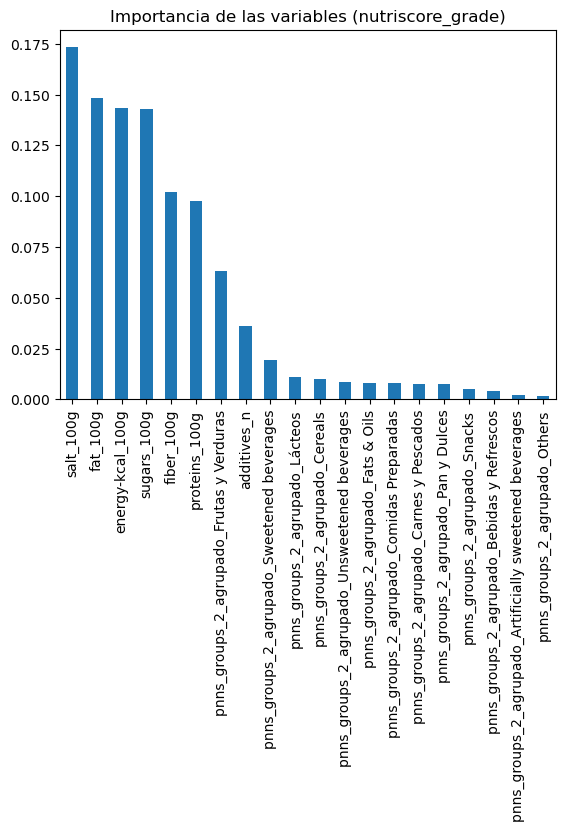

In [74]:
importances = pd.Series(model_clf.feature_importances_, index=X.columns)
importances.sort_values(ascending=False).plot(kind='bar')
plt.title('Importancia de las variables (nutriscore_grade)')
plt.show()

## 5. Evaluación y problemas

Aunque el modelo parece funcionar bastante bien debemos tener en cuenta que puede estar presentando unos resultados irreales debido a problemas estadísticos. El primer potencial problema de nuestro modelo puede ser la multicolinealidad entre variables que estén muy relacionadas, estudiemos la colinearidad del modelo.

In [75]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Calcular VIF para cada predictor
vif_data = pd.DataFrame()
vif_data["Variable"] = X_train.columns
vif_data["VIF"] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]

print(vif_data)

                                             Variable        VIF
0   pnns_groups_2_agrupado_Artificially sweetened ...   1.058414
1          pnns_groups_2_agrupado_Bebidas y Refrescos   1.011601
2            pnns_groups_2_agrupado_Carnes y Pescados   3.341267
3                      pnns_groups_2_agrupado_Cereals   3.327650
4           pnns_groups_2_agrupado_Comidas Preparadas   2.297092
5                  pnns_groups_2_agrupado_Fats & Oils   1.770961
6            pnns_groups_2_agrupado_Frutas y Verduras   1.486065
7                      pnns_groups_2_agrupado_Lácteos   1.534371
8                       pnns_groups_2_agrupado_Others   1.036224
9                 pnns_groups_2_agrupado_Pan y Dulces   5.154505
10                      pnns_groups_2_agrupado_Snacks   1.895311
11         pnns_groups_2_agrupado_Sweetened beverages   1.065303
12       pnns_groups_2_agrupado_Unsweetened beverages   1.020677
13                                   energy-kcal_100g  22.835808
14                       

Parece que la variable de calorías tiene un VIF muy alto y puede estar altamente correlacionada con el resto de variable de nuestro modelo, podríamos optar por eliminarla del modelo ya que a pesar de ser significativa su coeficiente en la regresión era muy bajo: 0.0090. De todas formas el resto de métricas indican que nuestro modelo es bastante explicativo y coherente.

Por último vamos a comprara los errores del set de entrenamiento y el de prueba ya que si nuestro set de entrenamiento funciona ostensiblemente mejor que nuestro set de prueba puede existir un problema de sobreajuste del modelo, nuestro modelo no estaría aprendiendo sino copiando datos

In [78]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Predicciones en ambos conjuntos
y_train_pred = model_reg.predict(X_train)
y_test_pred = model_reg.predict(X_test)

# Métricas para el conjunto de entrenamiento
mae_train = mean_absolute_error(y_train_score, y_train_pred)
mse_train = mean_squared_error(y_train_score, y_train_pred)
rmse_train = np.sqrt(mse_train)
r2_train = r2_score(y_train_score, y_train_pred)

# Métricas para el conjunto de prueba
mae_test = mean_absolute_error(y_test_score, y_test_pred)
mse_test = mean_squared_error(y_test_score, y_test_pred)
rmse_test = np.sqrt(mse_test)
r2_test = r2_score(y_test_score, y_test_pred)

# Comparación de resultados
print(f"Entrenamiento - MAE: {mae_train}, MSE: {mse_train}, RMSE: {rmse_train}, R²: {r2_train}")
print(f"Prueba - MAE: {mae_test}, MSE: {mse_test}, RMSE: {rmse_test}, R²: {r2_test}")

Entrenamiento - MAE: 2.1751367166735123, MSE: 8.199720285610939, RMSE: 2.863515371987889, R²: 0.8902405259762963
Prueba - MAE: 2.164391356810657, MSE: 8.151071284453787, RMSE: 2.8550081058473, R²: 0.8912345082858971


No hay sobre ajuste en regresión, los errores son equiparables

In [81]:
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score

# Predicciones en ambos conjuntos
y_train_pred = model_clf.predict(X_train)
y_test_pred = model_clf.predict(X_test)

# Métricas para el conjunto de entrenamiento
accuracy_train = accuracy_score(y_train_grade, y_train_pred)
roc_auc_train = roc_auc_score(y_train_grade, model_clf.predict_proba(X_train), multi_class='ovr')

# Métricas para el conjunto de prueba
accuracy_test = accuracy_score(y_test_grade, y_test_pred)
roc_auc_test = roc_auc_score(y_test_grade, model_clf.predict_proba(X_test), multi_class='ovr')

# Comparación de resultados
print(f"Entrenamiento - Accuracy: {accuracy_train}, ROC-AUC: {roc_auc_train}")
print(f"Prueba - Accuracy: {accuracy_test}, ROC-AUC: {roc_auc_test}")

Entrenamiento - Accuracy: 0.9972609049706761, ROC-AUC: 0.9999500050970787
Prueba - Accuracy: 0.8939620758483033, ROC-AUC: 0.9872862382500116


Desgraciadamente observamos señales de sobreajuste en nuestro modelo de clasificación, el moelo predice casi perfecto el conjunto de entrenamiento a diferencia que los datos test que llegan al 89%. Deeberíamos replantear corregir este sobreajuste o tomar como referencia nuestro modelo de regresión en su defecto

# Conclusión

El NutriScore parece ser una medida bastante completa para determinar cuan saludable es un alimento, emplea muchas características nutricionales de los alimentos y tiende a ser consistente en su sesgo. De todas formas, la alimentación es un tema muy complejo y valorar los alimentos sin tener en cuenta la cantidad consumida o la frecuencia de cada alimento puede no ser lo más adecuado para ainformar correctamente al consumidor sobre su consumo.

Cabe destacar que NutriScore ha evolucionado en ese aspecto y ha habido revisiones periódicas para tener en cuenta aspectos más allá de los nutricionales, un claro ejemplo de ello ha sido el aceite de oliva que se consideraba una C-D en sus inicios debido a altos niveles de calorías y grasas. Posteriormente se le asignó una B. 

Estos casos indican que no todos los modelos son autónomos a la hora de explicar un fenómeno sino que a veces hay que darle un sentido más allá desde el pensamiento crítico por parte de los analistas que estan realizando el estudio. En este caso informar a los consumidores es una tarea compleja que además conlleva una responsabilidad social implícita.

¡Espero que haya disfrutado del proyecto! 🎉🎉